# =======================

<span style="color:red; font-size:26px; font-weight:bold;">2.7.11. PIXEL-LEVEL DOMAIN TRANSFER USING GANS:</span>

# =======================

In [13]:
import kagglehub

In [14]:
import os

In [15]:
from PIL import Image

In [16]:
import matplotlib.pyplot as plt

In [17]:
import random

In [18]:
import torch

In [19]:
import torch.nn as nn

In [20]:
import torch.optim as optim

In [21]:
from torch.utils.data import Dataset, DataLoader

In [22]:
from torchvision import transforms

In [23]:
from torchvision.utils import save_image

In [24]:
from skimage.metrics import structural_similarity as ssim

In [25]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [26]:
import numpy as np

------

------

In [27]:
# Download Dataset

In [28]:
dataset_dir = kagglehub.dataset_download("balraj98/horse2zebra-dataset")

In [29]:
print("Dataset directory path:", dataset_dir)

Dataset directory path: /kaggle/input/horse2zebra-dataset


In [30]:
trainA_dir = os.path.join(dataset_dir, "trainA")

In [31]:
trainB_dir = os.path.join(dataset_dir, "trainB")

In [32]:
print(f"Number of Horse training images: {len(os.listdir(trainA_dir))}")
print(f"Number of Zebra training images: {len(os.listdir(trainB_dir))}")

Number of Horse training images: 1067
Number of Zebra training images: 1334


In [33]:
# Show sample images

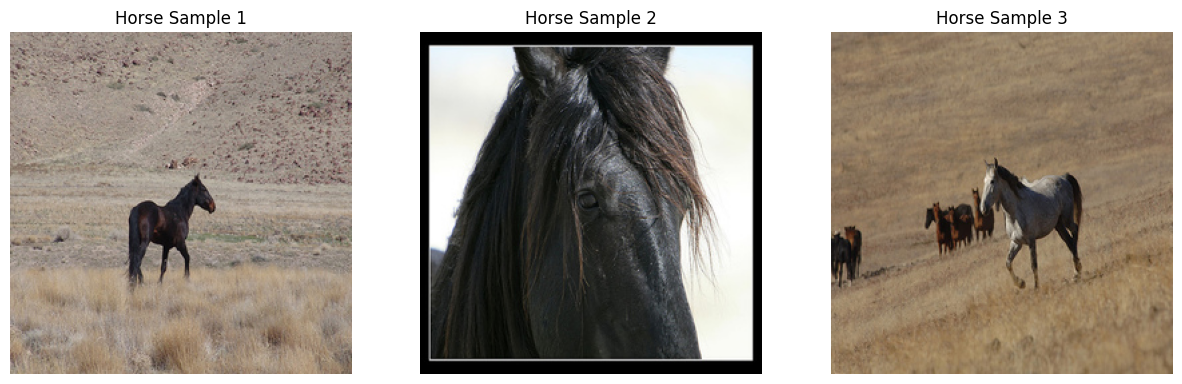

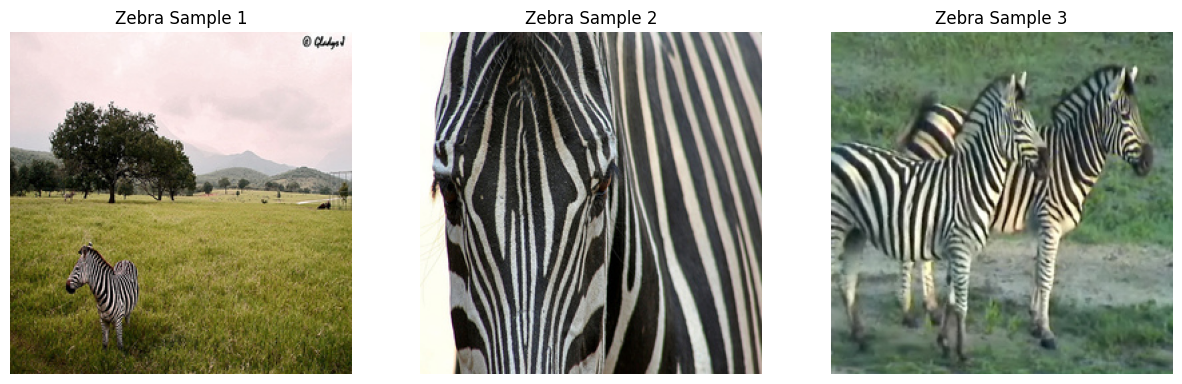

In [34]:
def show_sample_images(image_dir, domain_name, num=3):
    plt.figure(figsize=(15,5))
    img_files = os.listdir(image_dir)[:num]
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f"{domain_name} Sample {i+1}")
        plt.axis('off')
    plt.show()

show_sample_images(trainA_dir, "Horse")
show_sample_images(trainB_dir, "Zebra")

----

---

In [35]:
# Dataset Class

In [36]:
class UnpairedImageDataset(Dataset):
    def __init__(self, root_dir, domainA='trainA', domainB='trainB', transform=None, subset_size=None):
        self.dir_A = os.path.join(root_dir, domainA)
        self.dir_B = os.path.join(root_dir, domainB)

        self.files_A = sorted(os.listdir(self.dir_A))
        self.files_B = sorted(os.listdir(self.dir_B))

        if subset_size is not None:
            self.files_A = random.sample(self.files_A, min(subset_size, len(self.files_A)))
            self.files_B = random.sample(self.files_B, min(subset_size, len(self.files_B)))

        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A_path = os.path.join(self.dir_A, self.files_A[idx % len(self.files_A)])
        img_B_path = os.path.join(self.dir_B, self.files_B[idx % len(self.files_B)])

        img_A = Image.open(img_A_path).convert("RGB")
        img_B = Image.open(img_B_path).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}

----

----

In [37]:
# Generator + Discriminator Architectures

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [39]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=9):
        super(ResnetGenerator, self).__init__()

        model = [
            nn.Conv2d(input_nc, 64, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, 2, 1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, 2, 1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [nn.Conv2d(64, output_nc, 7, 1, 3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [40]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(PatchGANDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

----

------

In [41]:
# Initialize Models, Optimizers, Schedulers

In [42]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
G_AB = ResnetGenerator().to(device)

In [45]:
G_BA = ResnetGenerator().to(device)

In [46]:
D_A = PatchGANDiscriminator().to(device)

In [47]:
D_B = PatchGANDiscriminator().to(device)

In [48]:
G_AB.apply(weights_init_normal)

ResnetGenerator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stri

In [49]:
G_BA.apply(weights_init_normal)

ResnetGenerator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stri

In [50]:
D_A.apply(weights_init_normal)

PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [51]:
D_B.apply(weights_init_normal)

PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [52]:
lr = 0.0002

In [53]:
optimizer_G = optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(0.5, 0.999)
)

In [54]:
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))

In [55]:
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [56]:
def lambda_rule(epoch):
    decay_start_epoch = 100
    total_epochs = 200
    return 1.0 - max(0, epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

In [57]:
lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)

In [58]:
lr_scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)

In [59]:
lr_scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)

----

-----

In [60]:
# Losses & Helpers

In [61]:
criterion_GAN = nn.MSELoss()

In [62]:
criterion_cycle = nn.L1Loss()

In [63]:
criterion_identity = nn.L1Loss()

In [64]:
def save_sample_images(real_A, real_B, fake_A, fake_B, epoch, folder="samples"):
    os.makedirs(folder, exist_ok=True)
    def denorm(x): return (x + 1) / 2.0
    save_image(denorm(real_A), f"{folder}/real_A_{epoch}.png")
    save_image(denorm(real_B), f"{folder}/real_B_{epoch}.png")
    save_image(denorm(fake_B), f"{folder}/fake_B_{epoch}.png")
    save_image(denorm(fake_A), f"{folder}/fake_A_{epoch}.png")

----

-----

In [65]:
# Training Function

In [66]:
def train_cyclegan(
    dataloader, G_AB, G_BA, D_A, D_B,
    optimizer_G, optimizer_D_A, optimizer_D_B,
    lr_scheduler_G, lr_scheduler_D_A, lr_scheduler_D_B,
    epochs=5, lambda_cycle=10.0, lambda_identity=5.0, device="cuda"
):
    for epoch in range(1, epochs+1):
        for i, batch in enumerate(dataloader):
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            # Train Generators
            optimizer_G.zero_grad()
            same_B = G_AB(real_B)
            loss_identity_B = criterion_identity(same_B, real_B) * lambda_identity

            same_A = G_BA(real_A)
            loss_identity_A = criterion_identity(same_A, real_A) * lambda_identity

            fake_B = G_AB(real_A)
            pred_fake_B = D_B(fake_B)
            valid = torch.ones_like(pred_fake_B, device=device)
            loss_GAN_AB = criterion_GAN(pred_fake_B, valid)

            fake_A = G_BA(real_B)
            pred_fake_A = D_A(fake_A)
            loss_GAN_BA = criterion_GAN(pred_fake_A, valid)

            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A) * lambda_cycle

            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B) * lambda_cycle

            loss_G = loss_identity_A + loss_identity_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B
            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator A
            optimizer_D_A.zero_grad()
            pred_real = D_A(real_A)
            loss_D_real = criterion_GAN(pred_real, valid)

            pred_fake = D_A(fake_A.detach())
            fake = torch.zeros_like(pred_fake, device=device)
            loss_D_fake = criterion_GAN(pred_fake, fake)

            loss_D_A = (loss_D_real + loss_D_fake) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # Train Discriminator B
            optimizer_D_B.zero_grad()
            pred_real = D_B(real_B)
            loss_D_real = criterion_GAN(pred_real, valid)

            pred_fake = D_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)

            loss_D_B = (loss_D_real + loss_D_fake) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D_A loss: {loss_D_A.item():.4f}] [D_B loss: {loss_D_B.item():.4f}] [G loss: {loss_G.item():.4f}]")

        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        save_sample_images(real_A, real_B, fake_A, fake_B, epoch)
        print(f"Epoch {epoch} finished. Sample images saved.")

------

----

In [67]:
#  Prepare DataLoader & Train

In [68]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [69]:
use_subset = True

In [70]:
subset_size = 200 if use_subset else None

In [71]:
dataset = UnpairedImageDataset(
    root_dir="/kaggle/input/horse2zebra-dataset",
    domainA="trainA", domainB="trainB",
    transform=transform,
    subset_size=subset_size
)

In [72]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [73]:
train_cyclegan(
    dataloader, G_AB, G_BA, D_A, D_B,
    optimizer_G, optimizer_D_A, optimizer_D_B,
    lr_scheduler_G, lr_scheduler_D_A, lr_scheduler_D_B,
    epochs=5, device=device
)

[Epoch 1/5] [Batch 0/200] [D_A loss: 2.0249] [D_B loss: 1.8525] [G loss: 28.3849]
[Epoch 1/5] [Batch 100/200] [D_A loss: 0.3863] [D_B loss: 0.3206] [G loss: 9.8978]
Epoch 1 finished. Sample images saved.
[Epoch 2/5] [Batch 0/200] [D_A loss: 0.2672] [D_B loss: 0.2589] [G loss: 9.5496]
[Epoch 2/5] [Batch 100/200] [D_A loss: 0.3606] [D_B loss: 0.1836] [G loss: 8.6759]
Epoch 2 finished. Sample images saved.
[Epoch 3/5] [Batch 0/200] [D_A loss: 0.2015] [D_B loss: 0.2461] [G loss: 6.9011]
[Epoch 3/5] [Batch 100/200] [D_A loss: 0.2831] [D_B loss: 0.3409] [G loss: 10.9697]
Epoch 3 finished. Sample images saved.
[Epoch 4/5] [Batch 0/200] [D_A loss: 0.2431] [D_B loss: 0.1813] [G loss: 7.0147]
[Epoch 4/5] [Batch 100/200] [D_A loss: 0.2488] [D_B loss: 0.2421] [G loss: 7.4901]
Epoch 4 finished. Sample images saved.
[Epoch 5/5] [Batch 0/200] [D_A loss: 0.1762] [D_B loss: 0.2145] [G loss: 10.1184]
[Epoch 5/5] [Batch 100/200] [D_A loss: 0.2200] [D_B loss: 0.2166] [G loss: 9.0104]
Epoch 5 finished. Sam

-----

----

In [74]:
# Save Model Checkpoint

In [75]:
os.makedirs("checkpoints", exist_ok=True)

In [76]:
torch.save({
    'G_AB': G_AB.state_dict(),
    'G_BA': G_BA.state_dict(),
    'D_A': D_A.state_dict(),
    'D_B': D_B.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D_A': optimizer_D_A.state_dict(),
    'optimizer_D_B': optimizer_D_B.state_dict()
}, "checkpoints/cyclegan_horse2zebra.pth")

----

-----

In [77]:
# Evaluation (SSIM & PSNR)

In [78]:
def evaluate_cyclegan(dataloader, G_AB, G_BA, device="cuda"):
    G_AB.eval()
    G_BA.eval()

    ssim_scores = []
    psnr_scores = []

    with torch.no_grad():
        for batch in dataloader:
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            fake_B = G_AB(real_A)
            rec_A = G_BA(fake_B)

            real_A_np = ((real_A.squeeze().cpu().numpy() + 1) / 2).transpose(1,2,0)
            rec_A_np = ((rec_A.squeeze().cpu().numpy() + 1) / 2).transpose(1,2,0)

            ssim_score = ssim(real_A_np, rec_A_np, channel_axis=2, data_range=1.0)
            psnr_score = psnr(real_A_np, rec_A_np, data_range=1.0)

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)

    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")

evaluate_cyclegan(dataloader, G_AB, G_BA, device=device)

Average SSIM: 0.5531
Average PSNR: 16.92 dB


-----

-----

In [79]:
# Visualize 10 Samples

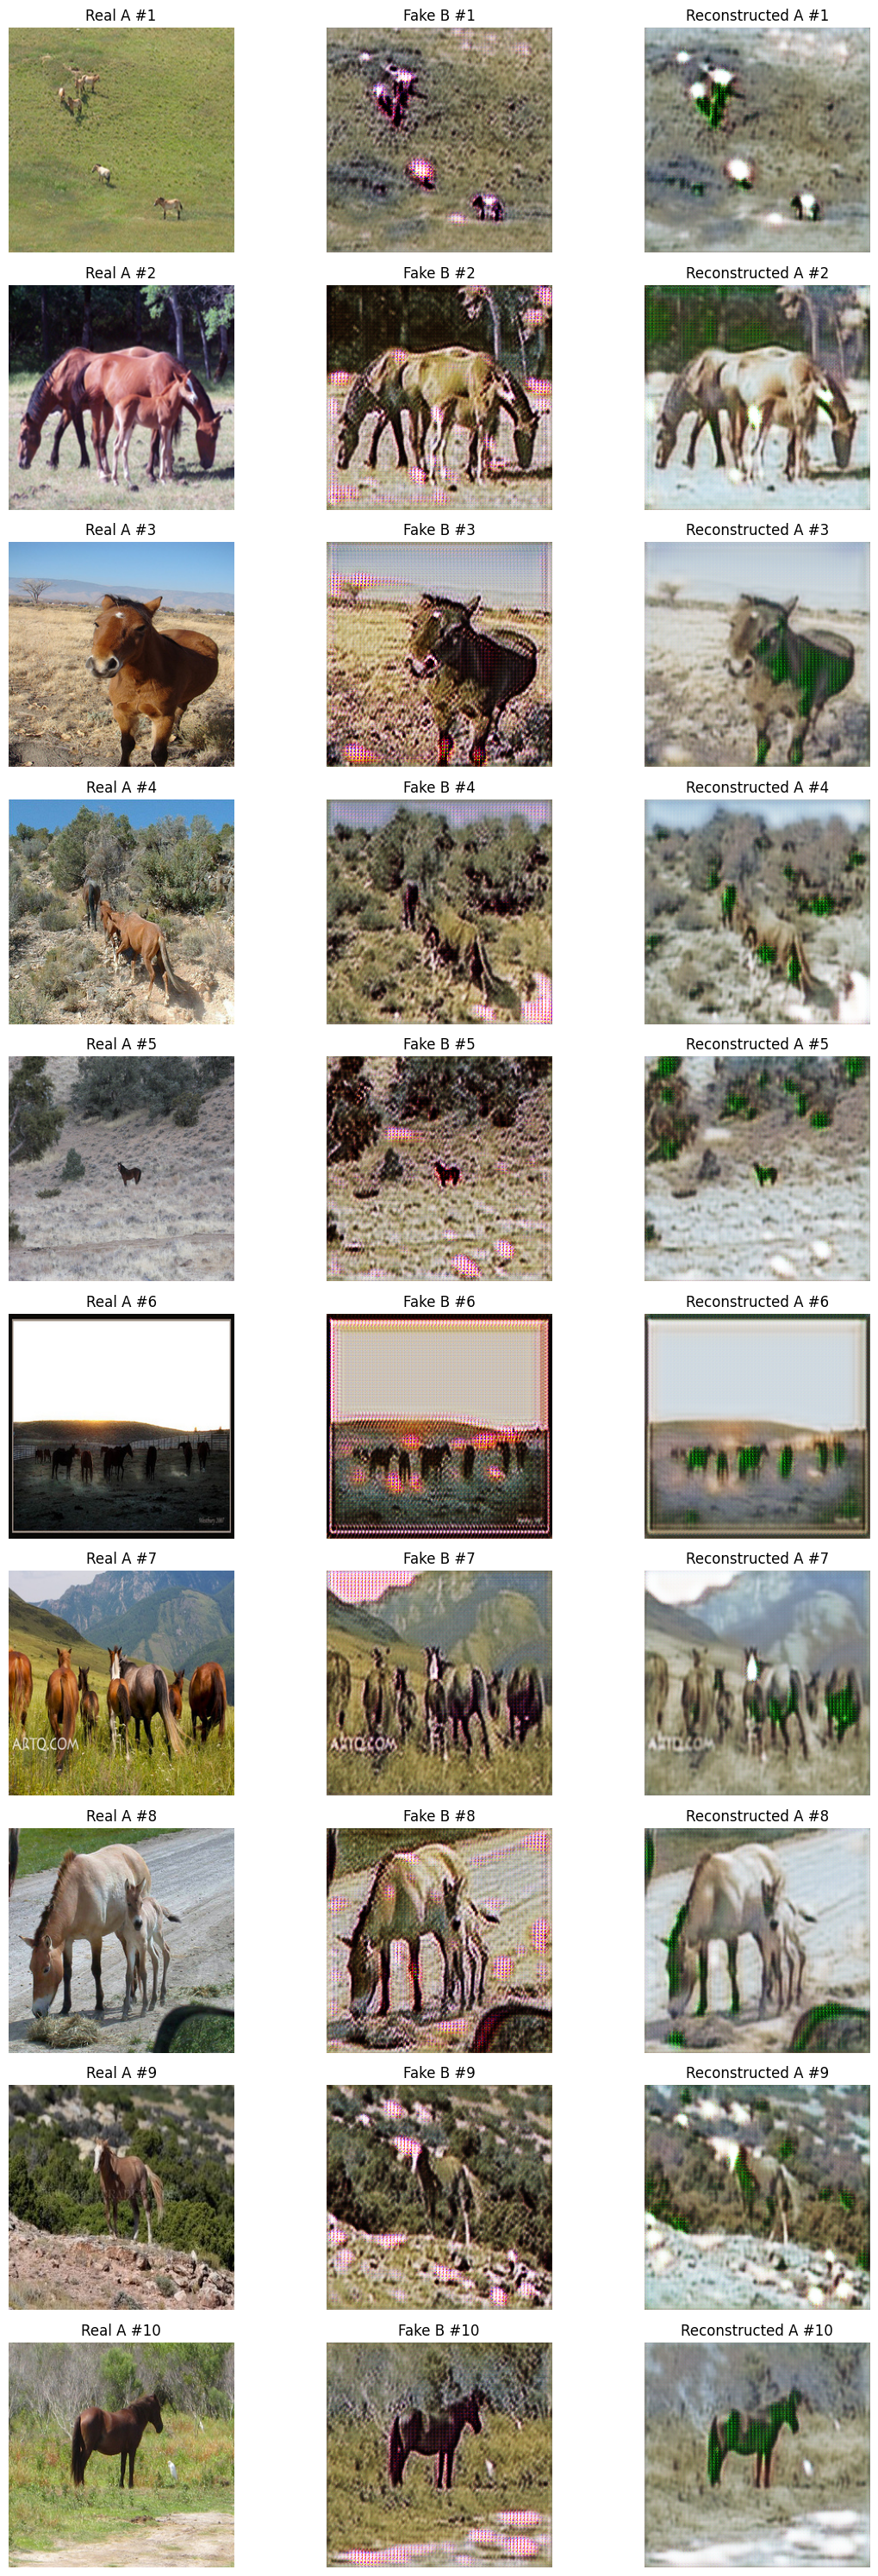

In [80]:
def visualize_multiple_samples(dataloader, G_AB, G_BA, device="cuda", num_samples=10):
    G_AB.eval()
    G_BA.eval()

    images = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            real_A = batch['A'].to(device)
            fake_B = G_AB(real_A)
            rec_A = G_BA(fake_B)

            def to_numpy(img):
                return ((img.squeeze().cpu().numpy() + 1) / 2).transpose(1, 2, 0)

            images.append((to_numpy(real_A), to_numpy(fake_B), to_numpy(rec_A)))

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 3*num_samples))
    for i, (real_A_np, fake_B_np, rec_A_np) in enumerate(images):
        axs[i, 0].imshow(real_A_np)
        axs[i, 0].set_title(f"Real A #{i+1}")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(fake_B_np)
        axs[i, 1].set_title(f"Fake B #{i+1}")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(rec_A_np)
        axs[i, 2].set_title(f"Reconstructed A #{i+1}")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_multiple_samples(dataloader, G_AB, G_BA, device=device, num_samples=10)

-----
-----